In [1]:
from pathlib import Path
import nltk
import gzip
import json
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from multiprocessing import Pool
import spacy
import time
import pickle
import multiprocessing as mp
import string
import en_core_web_sm
from nltk.tokenize import word_tokenize
from sklearn.base import TransformerMixin, BaseEstimator
from normalise import normalise
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer
from sklearn.preprocessing import LabelEncoder
import scikitplot as skplt
from sklearn.metrics import classification_report

nlp = en_core_web_sm.load();

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.semi_supervised.label_propagation module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.semi_supervised. Anything that cannot be imported from sklearn.semi_supervised is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelPropagation from version 0.18 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [2]:
for dependency in ("brown", "names", "wordnet", "averaged_perceptron_tagger", "universal_tagset"):
    nltk.download(dependency)

[nltk_data] Downloading package brown to /home/ubuntu/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package names to /home/ubuntu/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ubuntu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/ubuntu/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [3]:
DATA_FOLDER = Path('./data')
reviews = DATA_FOLDER / 'reviews_Home_and_Kitchen_5.json.gz'

VOCAB_SIZE = 120000     # how many unique words to use (i.e num rows in embedding vector)
NN_MAX_REVIEW_LEN = 128 # max number of words in review
EMBEDDING_SIZE = 300    # size of embeddings vector

In [4]:
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500
pd.options.display.width = 1000
pd.options.display.max_colwidth = 1000

## Data load and EDA

In [5]:
if not (DATA_FOLDER/'reviews.csv').exists():
    df = pd.DataFrame.from_records(map(json.loads, gzip.open(reviews)))
    df[['reviewText', 'overall']].to_csv(DATA_FOLDER/'reviews.csv')
df = pd.read_csv(DATA_FOLDER/'reviews.csv').set_index("Unnamed: 0")

In [6]:
df

,reviewText,overall
Unnamed: 0,,
0,My daughter wanted this book and the price on Amazon was the best. She has already tried one recipe a day after receiving the book. She seems happy with it.,5.0
1,I bought this zoku quick pop for my daughterr with her zoku quick maker. She loves it and have fun to make her own ice cream.,5.0
2,"There is no shortage of pop recipes available for free on the web, but I purchased the ""Zoku Quick Pops"" book, because Zoku has some good recipes for fruit pops on its blog. I was hoping there were more where those came from. This book emphasizes very sweet dessert pops, however. There are 41 recipes in total, only 13 of which are fruit pops. There is a ""Fresh and Fruity"" chapter, followed by three chapters of dessert pops entitled ""I Scream for Quick Pops!"", ""Bake Shop"", and ""Coco Loco"". As you might guess from the last one, there are 15 pop recipes that contain chocolate.Chapters on ""Tips"" and ""Techniques"" are useful. There is more detailed information about ingredients that don't freeze well in the Zoku than is found in the instruction manual. The book lists options for dairy products and sweeteners, tells you how to do different types of layers, how to add decorative fruit slices, how to do a quick shell, and how to make core pops. The pages about core pops are especially help...",4.0
3,"This book is a must have if you get a Zoku (which I also highly recommend). There is a large variety of recipes from simple, to fancy. The flavor combos are creative, and it gives you ideas for decorating the pops too. They turn out as beautiful as they are tasty. After reading it you will be inspired to create your own recipes too.",5.0
4,"This cookbook is great. I have really enjoyed reviewing all of the recipes. Sure - some are more difficult than others, but there is a nice variety in this book. For me it was totally worth it just to get the quick shell recipes alone. We have only tried the chocolate so far, but it is so tasty. A few of my favorite recipes in this book are the banana from the strawberry banana one, and the raspberry/blackberry ones (but I used mixed berries). Also, it has great instructions for tips on using the Zoku. Definitely recommended.",4.0
...,...,...
551677,"These ice pop molds are awesome! Bright kid-happy colors in just the right size portions. I received the package very quickly and immediately washed them out and filled them with different juice combos -- the next morning when I took one out to try it, it was tough to get the little lid off, but just a second or two under running water loosened things up enough to easily remove the lid. Very soft, squeezable molds with ridges that make them easy to grip -- and easy to push the pop up... looking forward to trying many different flavor combos over the summer!",5.0
551678,great popsicle molds - very nice quality - and the colors are pretty cool too!,5.0
551679,My kids and I are loving these - putting our creativity to the test - nicely made!-,5.0


In [7]:
df.shape

(551682, 2)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 551682 entries, 0 to 551681
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   reviewText  551466 non-null  object 
 1   overall     551682 non-null  float64
dtypes: float64(1), object(1)
memory usage: 12.6+ MB


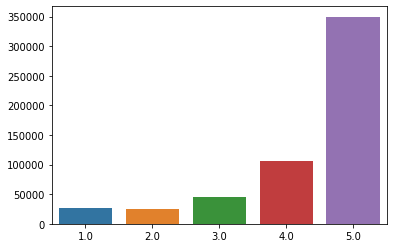

In [9]:
# total reviews by score
overall = df.overall.value_counts()
sns.barplot(overall.index, overall.values);

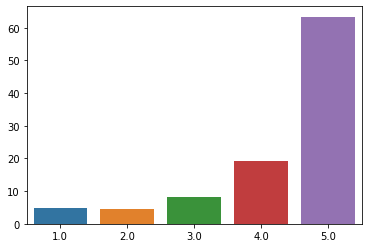

In [10]:
# percent distribution of ratings
as_perct = df['overall'].value_counts()/df['overall'].count()*100
sns.barplot(as_perct.index, as_perct.values);

In [11]:
# sample only 20k from each category

if not (DATA_FOLDER/'reviews_small.csv').exists():
    df = df.dropna()
    new_df_5 = df[df['overall']==5][:20000]
    new_df_4 = df[df['overall']==4][:20000]
    new_df_3 = df[df['overall']==3][:20000]
    new_df_2 = df[df['overall']==2][:20000]
    new_df_1 = df[df['overall']==1][:20000]
    pdList = [new_df_1,new_df_2,new_df_3,new_df_4,new_df_5]
    df = pd.concat(pdList)
    df[['reviewText', 'overall']].to_csv(DATA_FOLDER/'reviews_small.csv')
df = pd.read_csv(DATA_FOLDER/'reviews_small.csv').set_index("Unnamed: 0")

In [12]:
df.groupby(['overall']).count()

,reviewText
overall,
1.0,20000
2.0,20000
3.0,20000
4.0,20000
5.0,20000


In [13]:
df.columns = ["review","condition"]

In [14]:
# change data types to string so type(0) is a string and not an int
df['condition'] = df['condition'].apply(str)
df['review'] = df['review'].apply(str)

In [15]:
# finding the maxlen
df['len'] = df['review'].apply(lambda s : len(s))

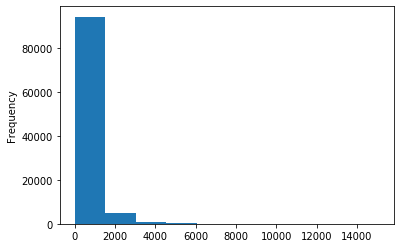

In [16]:
df['len'].plot.hist(bins=10)

In [17]:
df.len.quantile(0.9)

1185.0

In [18]:
del df['len']

## Text preprocessing

* _replace_contraction
* _clean_numbers
* _normalize (https://github.com/EFord36/normalise)
* _tokenize with spacy
* _remove_punct
* _remove_stop_words
* _clean - remove empty tokens
* lower


not lemmatizing 


In [19]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self,
                 variety="BrE",
                 user_abbrevs={},
                 n_jobs=1):
        """
        Text preprocessing transformer includes steps:
            1. Text normalization
            2. Punctuation removal
            3. Stop words removal
            4. Lemmatization
        
        variety - format of date (AmE - american type, BrE - british format) 
        user_abbrevs - dict of user abbreviations mappings (from normalise package)
        n_jobs - parallel jobs to run
        
        adapted from Maks Balatsko
        """

        self.variety = variety
        self.user_abbrevs = user_abbrevs
        self.n_jobs = n_jobs
        self.contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

    def fit(self, X, y=None):
        return self

    def transform(self, X, *_):
        X_copy = X.copy()

        partitions = 1
        cores = mp.cpu_count()
        if self.n_jobs <= -1:
            partitions = cores
        elif self.n_jobs <= 0:
            return X_copy.apply(self._preprocess_text)
        else:
            partitions = min(self.n_jobs, cores)

        data_split = np.array_split(X_copy, partitions)
        pool = mp.Pool(cores)
        data = pd.concat(pool.map(self._preprocess_part, data_split))
        pool.close()
        pool.join()

        return data

    def _preprocess_part(self, part):
        return part.apply(self._preprocess_text)

    def _preprocess_text(self, text):
        x = self._replace_contraction(text)
        x = self._clean_numbers(x)
        x = self._normalize(x)
        x = nlp(str(x))
        x = self._remove_punct(x)
        x = self._remove_stop_words(x)
        # NOTE: no lemmatization
        return self._clean(x).lower()
    
    def _clean_numbers(self, x):
        if bool(re.search(r'\d', x)):
            x = re.sub('[0-9]{5,}', '#####', x)
            x = re.sub('[0-9]{4}', '####', x)
            x = re.sub('[0-9]{3}', '###', x)
            x = re.sub('[0-9]{2}', '##', x)
        return x
    
    def _normalize(self, text):
        try:
            return ' '.join(normalise(text, variety=self.variety, user_abbrevs=self.user_abbrevs, verbose=False))
        except:
            return text
    
    def _replace_contraction(self, text):
        contraction_re = re.compile('(%s)' % '|'.join(self.contraction_dict.keys()))
        return contraction_re.sub(lambda x: self.contraction_dict[x.group(0)], text)
    
    def _remove_punct(self, doc):
        return [t for t in doc if t.text not in string.punctuation]

    def _remove_stop_words(self, doc):
        return [t for t in doc if not t.is_stop]
    
    def _clean(self, doc):
        return ' '.join([i.text for i in doc if i])

    def _lemmatize(self, doc):
        return ' '.join([t.lemma_ for t in doc])

In [20]:
%%time

if not (DATA_FOLDER/'reviews_clean.csv').exists():
    text = TextPreprocessor(n_jobs=-1).transform(df.review)
    df["clean_text"] = text
    df.to_csv(DATA_FOLDER/'reviews_clean.csv')
df = pd.read_csv(DATA_FOLDER/'reviews_clean.csv').set_index("Unnamed: 0").astype({"clean_text": str, "condition": str})

CPU times: user 686 ms, sys: 67.9 ms, total: 754 ms
Wall time: 754 ms


In [21]:
df

,review,condition,clean_text
Unnamed: 0,,,
40,This is so remedial. Buy a Wilton magazine for less money and get more ideas and instructions for your investment.,1.0,remedial buy wilton magazine money ideas instructions investment
120,"I did sloppy shopping. This machine is exactly what the name says it is - a speller. I wanted definitions, OH, that would be a dictionary! I ordered a dictionary an I am happy - except the voice is scratchy. Life is not perfect.gg",1.0,sloppy shopping machine exactly says speller wanted definitions oh dictionary ordered dictionary happy voice scratchy life perfect.gg
127,"If you type the wrong word in, it &#34;might&#34; produce the correct word. It doesn't give any explanation of the meaning or how it can be used. I should have sent it bk., but I factored in the cost of return shipping - wasn't worth the return.",1.0,type wrong word produce correct word explanation meaning sent bk factored cost return shipping worth return
139,"I'm very disappointed in this device. It's basically just a coat hanger with two plastic guides. The only thing it has going for it is portability. It can only hold regular sized hard covered books. Forget about any size paperback, it will not work. Even hard cover books are nearly impossible to align correctly and they slip and slump in all kinds of odd positions. Then you have to completely remove the book from the stand every time you need to turn a page and try to realign it all over again. I tried with over 10 textbooks and it didn't do well with any of them. For home reading I'm going to buy and suggest you buy a more substantial stand. The only reason to keep it is to slip in a backpack and take with you and hope you have the desk space wherever you take it to use it.",1.0,disappointed device basically coat hanger plastic guides thing going portability hold regular sized hard covered books forget size paperback work hard cover books nearly impossible align correctly slip slump kinds odd positions completely remove book stand time need turn page try realign tried textbooks home reading going buy suggest buy substantial stand reason slip backpack hope desk space use
225,"Can't chop anything well. [Tried onions, tomatoes, celery, olives, nuts, and many other items.] Tried 2, 4, and 8-oz loads. Tried 1/8, 1/4, 1/2 cup loads.All you get is half mush and the other half ""as is"".I think it could ""mix"" 1/4 cup of cooked rice with a 1/2 cup of water ... but who needs that?This will be the last Cuisinart product I'll buy; their griddler, blender, and ice cream maker are poorly engineered too ... and I long ago stopped using them.",1.0,"chop tried onions tomatoes celery olives nuts items tried 2 4 8-oz loads tried 1/8 1/4 1/2 cup loads half mush half is"".i think mix 1/4 cup cooked rice 1/2 cup water ... needs that?this cuisinart product buy griddler blender ice cream maker poorly engineered ... long ago stopped"
...,...,...,...
29729,This is a very good item for someone with small chopping jobs. Everything works fine very easy to clean very easy to the store,5.0,good item small chopping jobs works fine easy clean easy store
29730,i love this black and decker cup chopper. first the price 19.99 and second easy to clean. i thought to spend a couple of hundreds on a chopper but thanks god i found this.,5.0,love black decker cup chopper price second easy clean thought spend couple hundreds chopper thanks god found
29731,"I have used this food chopper several times now, and I like the way it works. I have used it to chop ginger root, garlic, onions, peppers, and cherry tomatoes. I like the way I can control the amount of chopping such as in the case of the cherry tomatoes since I did not want to make them into a sauce but just chopped; this product gave me good control. The other food items were finely chopped, and the recipes came out great: talapia in lemon sauce, lemony salmon, and orange chicken. Spooning the chopped food out of the container was very easy, and the clean up

### Count tokens

In [14]:
if not (DATA_FOLDER/'words_count.pkl').exists():
    counter = Counter([w for s in df.clean_text.values for w in s.split()])
    pickle.dump(counter, open(DATA_FOLDER/'words_count.pkl', 'wb'))
counter = pickle.load(open(DATA_FOLDER/'words_count.pkl', 'rb'))

In [15]:
counter.most_common(20)

[('use', 46032),
 ('like', 36113),
 ('good', 26028),
 ('time', 25082),
 ('coffee', 21809),
 ('great', 21707),
 ('water', 19683),
 ('product', 18614),
 ('bought', 18040),
 ('little', 17552),
 ('...', 17197),
 ('clean', 14941),
 ('better', 14720),
 ('work', 14668),
 ('easy', 14282),
 ('small', 13806),
 ('plastic', 13749),
 ('years', 13744),
 ('buy', 12715),
 ('works', 12697)]

### most common negative

In [52]:
Counter([w for s in df[df.condition.isin(['1.0', '2.0'])].clean_text.values for w in s.split()]).most_common(20)

[('use', 16205),
 ('like', 14190),
 ('time', 11023),
 ('product', 10061),
 ('good', 9860),
 ('coffee', 9184),
 ('water', 9059),
 ('bought', 8809),
 ('...', 8154),
 ('work', 7028),
 ('buy', 6655),
 ('plastic', 6419),
 ('better', 6341),
 ('great', 6260),
 ('thing', 6190),
 ('got', 5827),
 ('way', 5819),
 ('unit', 5732),
 ('amazon', 5530),
 ('2', 5431)]

### most common positive

In [53]:
Counter([w for s in df[df.condition.isin(['4.0', '5.0'])].clean_text.values for w in s.split()]).most_common(20)

[('use', 21330),
 ('like', 14987),
 ('great', 13995),
 ('good', 12490),
 ('easy', 10375),
 ('time', 9598),
 ('coffee', 9411),
 ('little', 8599),
 ('clean', 7849),
 ('works', 7459),
 ('water', 7180),
 ('bought', 6894),
 ('love', 6840),
 ('years', 6702),
 ('pan', 6407),
 ('nice', 5800),
 ('product', 5715),
 ('set', 5644),
 ('...', 5580),
 ('small', 5536)]

## train/test split

In [24]:
train_X, test_X, train_y, test_y = train_test_split(
    df.clean_text.values, 
    df.condition.values,
    stratify=df.condition.values, 
    test_size=0.25)

In [25]:
%%time
## Tokenize the sentences
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(list(train_X.astype(str)))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=NN_MAX_REVIEW_LEN)
test_X = pad_sequences(test_X, maxlen=NN_MAX_REVIEW_LEN)

CPU times: user 7.81 s, sys: 1.44 s, total: 9.25 s
Wall time: 9.24 s


In [26]:
le = LabelEncoder()
train_y = le.fit_transform(train_y)
test_y = le.transform(test_y)

In [27]:
le.classes_

array(['1.0', '2.0', '3.0', '4.0', '5.0'], dtype=object)

## load embeddings


In [22]:
def load_glove(word_index):
    """
    from https://www.kaggle.com/gmhost/gru-capsule
    """
    
    EMBEDDING_FILE = DATA_FOLDER / 'glove.840B.300d.txt'
    
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')[:300]
    
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(VOCAB_SIZE, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= VOCAB_SIZE: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [23]:
%%time
if not (DATA_FOLDER/'glove.pkl').exists():
    embedding_matrix = load_glove(tokenizer.word_index)
    pickle.dump(embedding_matrix, open(DATA_FOLDER/'glove.pkl', 'wb'))
    
embedding_matrix = pickle.load(open(DATA_FOLDER/'glove.pkl', 'rb'))

CPU times: user 32.8 ms, sys: 136 ms, total: 168 ms
Wall time: 168 ms


In [59]:
embedding_matrix.shape

(53640, 300)

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    print(f"CUDA is available! Training on {torch.cuda.get_device_name(0)}...")
    device = torch.device("cuda:0")
else:
    print("CUDA is not available. Training on CPU...")
    device = 'cpu'

CUDA is available! Training on Tesla T4...



## train TextCNN model
Takes about 16minutes to train on full Home and Kitchen segment which contains ~550k reviews. When subset to 20k from each rating trains in about 35seconds per epoch


In [74]:
class CNN_Text(nn.Module):
    
    def __init__(self):
        super(CNN_Text, self).__init__()
        filter_sizes = [1,2,3,5]
        num_filters = 36
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(VOCAB_SIZE, EMBEDDING_SIZE)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, EMBEDDING_SIZE)) for K in filter_sizes])
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, n_classes)


    def forward(self, x):
        x = self.embedding(x)  
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)  
        logit = self.fc1(x) 
        return logit

def clip_gradient(model, clip_value):
    params = list(filter(lambda p: p.grad is not None, model.parameters()))
    for p in params:
        p.grad.data.clamp_(-clip_value, clip_value)

In [34]:
n_epochs = 10
batch_size = 512

In [76]:
model = CNN_Text()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        clip_gradient(model, 1e-1)
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] = F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1/10 	 loss=687.8725 	 val_loss=627.9044  	 val_acc=0.4720  	 time=8.71s
Epoch 2/10 	 loss=608.7945 	 val_loss=601.2280  	 val_acc=0.4895  	 time=8.42s
Epoch 3/10 	 loss=579.2513 	 val_loss=590.5663  	 val_acc=0.4964  	 time=8.52s
Epoch 4/10 	 loss=557.5950 	 val_loss=584.5860  	 val_acc=0.5006  	 time=8.93s
Epoch 5/10 	 loss=539.8556 	 val_loss=580.1081  	 val_acc=0.5038  	 time=8.57s
Epoch 6/10 	 loss=523.3080 	 val_loss=581.1037  	 val_acc=0.5038  	 time=8.54s
Epoch 7/10 	 loss=508.2051 	 val_loss=578.4142  	 val_acc=0.5092  	 time=9.00s
Epoch 8/10 	 loss=493.9603 	 val_loss=581.6347  	 val_acc=0.5053  	 time=8.76s
Epoch 9/10 	 loss=480.5950 	 val_loss=583.4449  	 val_acc=0.5062  	 time=8.92s
Epoch 10/10 	 loss=469.3722 	 val_loss=591.2291  	 val_acc=0.5007  	 time=9.08s


In [77]:
torch.save(model,'amazon_balanced_textcnn_model')

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CNN_Text. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [37]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

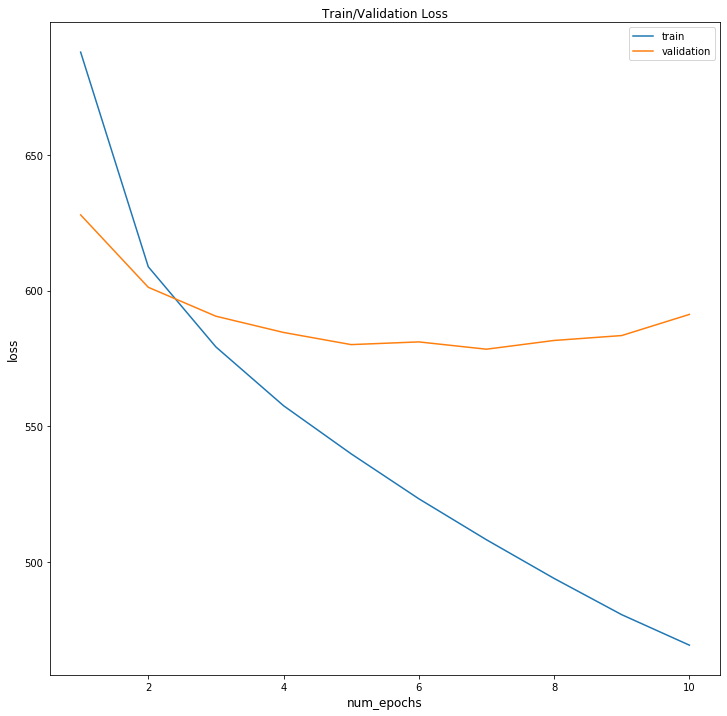

In [79]:
plot_graph(n_epochs)

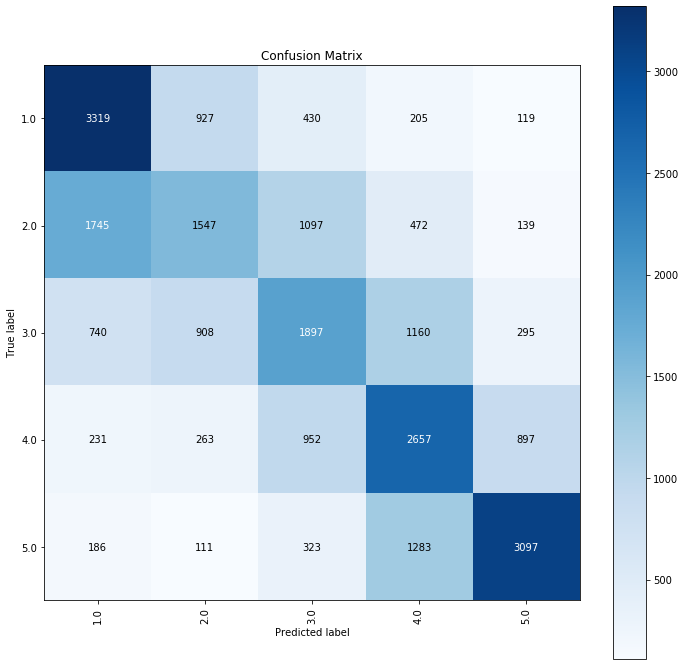

In [83]:
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

In [94]:
print("<<Bidirectional LSTM classification>> \n")
print(classification_report(y_true,y_pred))

<<Bidirectional LSTM classification>> 

              precision    recall  f1-score   support

         1.0       0.58      0.50      0.54      5000
         2.0       0.38      0.39      0.39      5000
         3.0       0.37      0.37      0.37      5000
         4.0       0.44      0.48      0.46      5000
         5.0       0.64      0.65      0.64      5000

    accuracy                           0.48     25000
   macro avg       0.48      0.48      0.48     25000
weighted avg       0.48      0.48      0.48     25000



# Pytorch Model - BiLSTM


In [32]:
class BiLSTM(nn.Module):
    
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size = 64
        drp = 0.1
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(VOCAB_SIZE, EMBEDDING_SIZE)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(EMBEDDING_SIZE, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        #rint(x.size())
        h_embedding = self.embedding(x)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [35]:
n_epochs = 30
model = BiLSTM()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1/30 	 loss=775.2714 	 val_loss=710.0168  	 val_acc=0.3810  	 time=6.24s
Epoch 2/30 	 loss=671.4873 	 val_loss=647.0993  	 val_acc=0.4328  	 time=5.84s
Epoch 3/30 	 loss=625.1856 	 val_loss=626.6615  	 val_acc=0.4541  	 time=5.89s
Epoch 4/30 	 loss=597.7531 	 val_loss=613.3324  	 val_acc=0.4639  	 time=6.22s
Epoch 5/30 	 loss=575.0175 	 val_loss=605.4245  	 val_acc=0.4745  	 time=5.94s
Epoch 6/30 	 loss=555.8821 	 val_loss=606.5428  	 val_acc=0.4710  	 time=6.01s
Epoch 7/30 	 loss=542.0326 	 val_loss=601.7699  	 val_acc=0.4809  	 time=6.34s
Epoch 8/30 	 loss=522.5522 	 val_loss=608.6942  	 val_acc=0.4773  	 time=6.08s
Epoch 9/30 	 loss=505.0505 	 val_loss=610.0180  	 val_acc=0.4793  	 time=6.39s
Epoch 10/30 	 loss=489.7997 	 val_loss=636.0613  	 val_acc=0.4694  	 time=6.07s
Epoch 11/30 	 loss=473.5656 	 val_loss=636.2825  	 val_acc=0.4737  	 time=6.43s
Epoch 12/30 	 loss=457.6684 	 val_loss=649.6199  	 val_acc=0.4735  	 time=6.16s
Epoch 13/30 	 loss=441.6012 	 val_loss=653.1752  

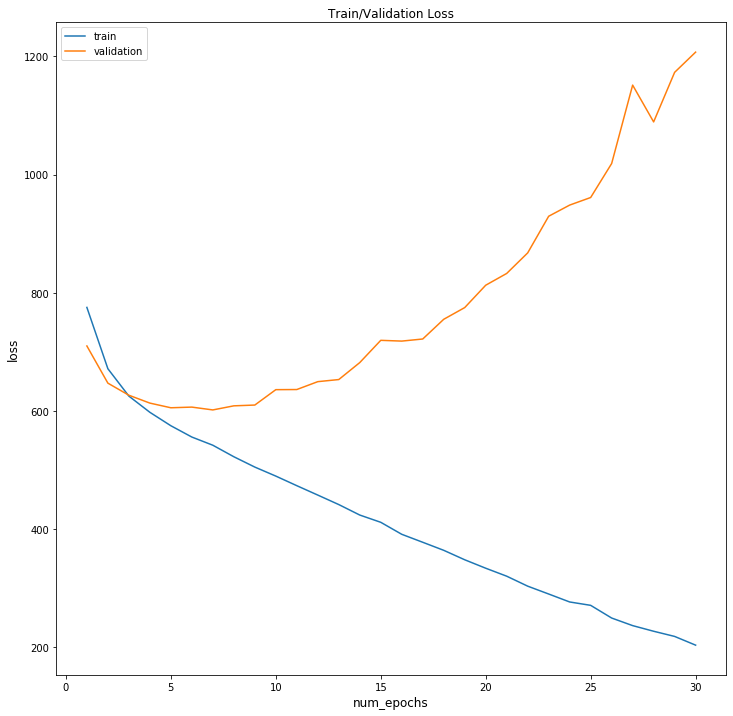

In [38]:
plot_graph(n_epochs)

In [92]:
torch.save(model,'amazon_balanced_bilstm_model')

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type BiLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


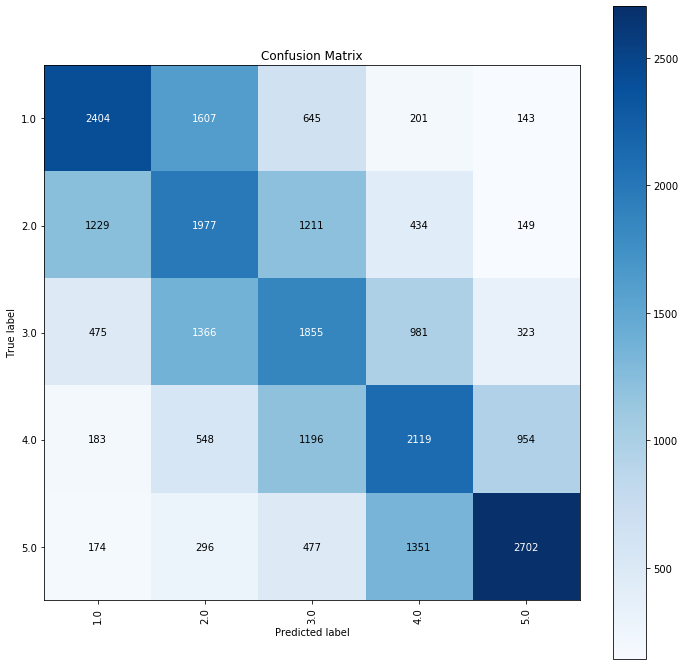

In [39]:
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

In [40]:
print("<<Bidirectional LSTM classification>> \n")
print(classification_report(y_true,y_pred))

<<Bidirectional LSTM classification>> 

              precision    recall  f1-score   support

         1.0       0.54      0.48      0.51      5000
         2.0       0.34      0.40      0.37      5000
         3.0       0.34      0.37      0.36      5000
         4.0       0.42      0.42      0.42      5000
         5.0       0.63      0.54      0.58      5000

    accuracy                           0.44     25000
   macro avg       0.45      0.44      0.45     25000
weighted avg       0.45      0.44      0.45     25000



## Deploy : Predict A Single Example

In [134]:
def predict_single(x):
    
    x = TextPreprocessor(n_jobs=1).transform( pd.DataFrame.from_dict({"review": [x]}).review).values[0]
    # tokenize
    x = tokenizer.texts_to_sequences([x])
    # pad
    x = pad_sequences(x, maxlen=NN_MAX_REVIEW_LEN)
    # create dataset
    x = torch.tensor(x, dtype=torch.long).cuda()

    pred = model(x).detach()
    pred = F.softmax(pred).cpu().numpy()

    pred = pred.argmax(axis=1)

    pred = le.classes_[pred]
    return pred[0]


In [138]:
df.iloc[20]

review        This blender is unreliable and does not work well for smoothies (our main use for a blender). When the cutter assembly broke (after ~20 uses) I contacted Cuisinart about a warranty replacement. Since the blender was purchased as a gift (from our wedding registry), we did not have "proof of purchase" and Cuisinart did not honor the 3-year warranty.We purchased a replacement part from CuisinartWebstore.com (~$21 with shipping) and got through another ~10 uses before that cutter assembly broke as well. This time with a proof of purchase in hand I called cuisinart customer "service" again only to learn they do not warranty items bought at the webstore (i.e. the replacement part had no warranty).If we could rate a company / brand here as well I would give one star to Cuisinart (i.e. Conair) for their shoddy product quality and poor customer service.
condition                                                                                                                        

In [142]:
df.iloc[80000]

review        My daughter wanted this book and the price on Amazon was the best.  She has already tried one recipe a day after receiving the book.  She seems happy with it.
condition                                                                                                                                                                5.0
clean_text                                                                                  daughter wanted book price Amazon best   tried recipe day receiving book   happy
Name: 0, dtype: object

In [139]:
predict_single(df.iloc[20].review)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


'1.0'

In [143]:
predict_single(df.iloc[80000].review)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


'5.0'

## Transformers model

In [41]:
# # Converting the codes to appropriate categories using a dictionary
my_dict = {
    '1.0':'one',
    '2.0':'two',
    '3.0':'three',
    '4.0':'four',
    '5.0':'five',
}

In [42]:
df['condition'] = df['condition'].apply(lambda x: my_dict[x])

In [43]:
encode_dict = {}
def encode_cat(x):
    if x not in encode_dict.keys():
        encode_dict[x]=len(encode_dict)
    return encode_dict[x]

df['condition_enc'] = df['condition'].apply(lambda x: encode_cat(x))

In [44]:
df

,review,condition,clean_text,condition_enc
Unnamed: 0,,,,
40,This is so remedial. Buy a Wilton magazine for less money and get more ideas and instructions for your investment.,one,remedial buy wilton magazine money ideas instructions investment,0
120,"I did sloppy shopping. This machine is exactly what the name says it is - a speller. I wanted definitions, OH, that would be a dictionary! I ordered a dictionary an I am happy - except the voice is scratchy. Life is not perfect.gg",one,sloppy shopping machine exactly says speller wanted definitions oh dictionary ordered dictionary happy voice scratchy life perfect.gg,0
127,"If you type the wrong word in, it &#34;might&#34; produce the correct word. It doesn't give any explanation of the meaning or how it can be used. I should have sent it bk., but I factored in the cost of return shipping - wasn't worth the return.",one,type wrong word produce correct word explanation meaning sent bk factored cost return shipping worth return,0
139,"I'm very disappointed in this device. It's basically just a coat hanger with two plastic guides. The only thing it has going for it is portability. It can only hold regular sized hard covered books. Forget about any size paperback, it will not work. Even hard cover books are nearly impossible to align correctly and they slip and slump in all kinds of odd positions. Then you have to completely remove the book from the stand every time you need to turn a page and try to realign it all over again. I tried with over 10 textbooks and it didn't do well with any of them. For home reading I'm going to buy and suggest you buy a more substantial stand. The only reason to keep it is to slip in a backpack and take with you and hope you have the desk space wherever you take it to use it.",one,disappointed device basically coat hanger plastic guides thing going portability hold regular sized hard covered books forget size paperback work hard cover books nearly impossible align correctly slip slump kinds odd positions completely remove book stand time need turn page try realign tried textbooks home reading going buy suggest buy substantial stand reason slip backpack hope desk space use,0
225,"Can't chop anything well. [Tried onions, tomatoes, celery, olives, nuts, and many other items.] Tried 2, 4, and 8-oz loads. Tried 1/8, 1/4, 1/2 cup loads.All you get is half mush and the other half ""as is"".I think it could ""mix"" 1/4 cup of cooked rice with a 1/2 cup of water ... but who needs that?This will be the last Cuisinart product I'll buy; their griddler, blender, and ice cream maker are poorly engineered too ... and I long ago stopped using them.",one,"chop tried onions tomatoes celery olives nuts items tried 2 4 8-oz loads tried 1/8 1/4 1/2 cup loads half mush half is"".i think mix 1/4 cup cooked rice 1/2 cup water ... needs that?this cuisinart product buy griddler blender ice cream maker poorly engineered ... long ago stopped",0
...,...,...,...,...
29729,This is a very good item for someone with small chopping jobs. Everything works fine very easy to clean very easy to the store,five,good item small chopping jobs works fine easy clean easy store,4
29730,i love this black and decker cup chopper. first the price 19.99 and second easy to clean. i thought to spend a couple of hundreds on a chopper but thanks god i found this.,five,love black decker cup chopper price second easy clean thought spend couple hundreds chopper thanks god found,4
29731,"I have used this food chopper several times now, and I like the way it works. I have used it to chop ginger root, garlic, onions, peppers, and cherry tomatoes. I like the way I can control the amount of chopping such as in the case of the cherry tomatoes since I did not want to make them into a sauce but just chopped; this product gave me good control. The other food items were finely chopped, and the recipes came out great: talapia in lemon sauce, lemony salmon, and orange chicken. Spooning the chopped food out of the contai

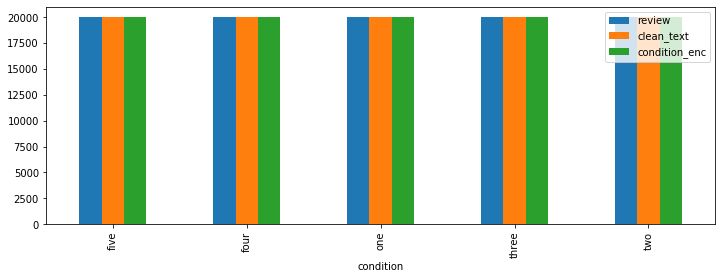

In [24]:
df.groupby([df["condition"]]).count().plot.bar(figsize=(12,4))


In [45]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 16
EPOCHS = 2
LEARNING_RATE = 1e-05
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [46]:
class Triage(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        text = str(self.data.clean_text[index])
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.condition_enc[index], dtype=torch.float)
        } 
    
    def __len__(self):
        return self.len

In [47]:
train_size = 0.8
train_dataset=df.sample(frac=train_size,random_state=200)

In [48]:
test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
train_dataset.reset_index(drop=True, inplace=True)

In [49]:
print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = Triage(train_dataset, tokenizer, MAX_LEN)
testing_set = Triage(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (100000, 4)
TRAIN Dataset: (80000, 4)
TEST Dataset: (20000, 4)


In [50]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)


In [51]:
class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = transformers.DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 1)
    
    def forward(self, ids, mask):
        output_1= self.l1(ids, mask)
        output_2 = self.l2(output_1[0])
        output = self.l3(output_2)
        return output

In [52]:
model = DistillBERTClass()
model.to(device)

DistillBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_feat

In [53]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [54]:
def train(epoch):
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask).squeeze()

        optimizer.zero_grad()

        loss = loss_function(outputs, targets)
        if _ % 500 == 0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [55]:
def valid(model, testing_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask).squeeze()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            total+=targets.size(0)
            n_correct+=(big_idx==targets).sum().item()
    return (n_correct*100.0)/total

In [60]:
for epoch in range(EPOCHS):
    train(epoch)
    val_acc = valid(model, testing_loader)
    print(f"Validation accuracy - {val_acc}")

Epoch: 0, Loss:  1.0578205585479736
Epoch: 0, Loss:  1.1335902214050293
Epoch: 0, Loss:  1.1137773990631104
Epoch: 0, Loss:  0.8757357597351074
Epoch: 0, Loss:  0.9504125714302063
Validation accuracy - 51.22
Epoch: 1, Loss:  0.8876297473907471
Epoch: 1, Loss:  1.06541907787323
Epoch: 1, Loss:  1.0367076396942139
Epoch: 1, Loss:  1.005798101425171
Epoch: 1, Loss:  1.1133477687835693
Validation accuracy - 52.05


In [61]:
# takes couple minutes to run on total data of 40k
print('This is the validation section to print the accuracy and see how it performs')
print('Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch')

acc = valid(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

This is the validation section to print the accuracy and see how it performs
Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch
Accuracy on test data = 52.05%
